#Deep Learning con Python
`Autor: Erwing FC 
~erwingforerocastro@gmail.com`

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
result_prefix = "sky_dream"

# Estos son los nombres de las capas
# para los que intentamos maximizar la activación,
# así como su peso en la pérdida final
# intentamos maximizar.
# Puede modificar estos ajustes para obtener nuevos efectos visuales.
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# Jugar con estos hiperparámetros también te permitirá lograr nuevos efectos
step = 0.01  # Tamaño del paso de ascenso en gradiente
num_octave = 3  # Número de escalas en las que se ejecuta el ascenso por gradiente
octave_scale = 1.4  # Relación de tamaño entre escalas
iterations = 20  # Número de pasos de ascenso por escala
max_loss = 15.0

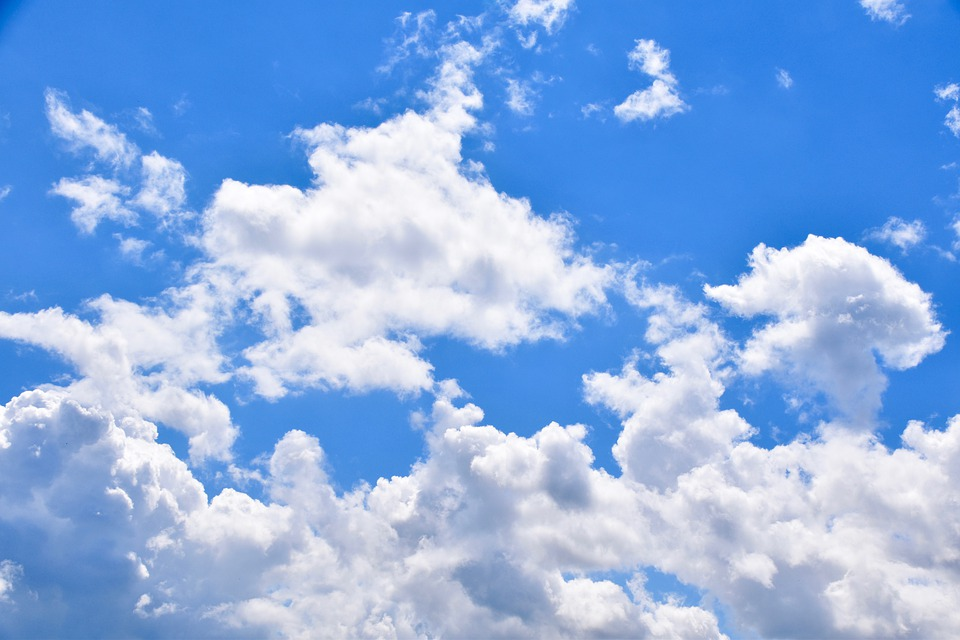

In [15]:
#esta es la imagen
from IPython.display import Image, display

display(Image(base_image_path))

Configuremos algunas utilidades de preprocesamiento / deprocesamiento de imágenes:

In [16]:
def preprocess_image(image_path):
    # Función util para abrir, cambiar el tamaño y formatear imágenes
    # en matrices apropiadas.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util función para convertir una matriz NumPy en una imagen válida.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Deshacer el preprocesamiento de inception v3
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convierta a uint8 y recorte al rango válido [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

###Calculo de la perdida de deep dream

Primero, se crea un modelo de extracción de características para recuperar las activaciones de nuestras capas de destino dada una imagen de entrada.

In [17]:
# Se crea un modelo InceptionV3 cargado con pesos de ImageNet entrenados previamente
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Se obtiene las salidas simbólicas de cada capa "clave" (se les da nombres únicos).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# se configura un modelo que devuelva los valores de activación para cada capa objetivo
# (como un dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

######Calculo de la perdida real

In [18]:
def compute_loss(input_image):
    features = feature_extractor(input_image) 
    # Inicializar la pérdida
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name] #valor de la capa
        activation = features[name]  #valor de 
        # Evitamos los artefactos de borde al involucrar solo píxeles que no son de borde en la pérdida.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32")) #tamaño de la imagen por ejem: 100x200X3
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling 
    return loss

######Se configura el bucle de ascenso de gradiente para una octava

In [19]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Calcular gradientes.
    grads = tape.gradient(loss, img)
    # Normalizar gradientes.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Valor de pérdida en el paso %d: %.2f" % (i, loss))
    return img

######Ejecuta el ciclo de entrenamiento, iterando sobre diferentes octavas

In [20]:
original_img = preprocess_image(base_image_path) #preprocesa la imagen
original_shape = original_img.shape[1:3] #tomamos el tamaño de la imagen ej: (1,200,400,3)=(200,400)
successive_shapes = [original_shape] # por ej: [(200,400)]

for i in range(1, num_octave): #(1,3)
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape]) #una tupla de cada dimension/3^i
    successive_shapes.append(shape) #agregamos el valor al vector

successive_shapes = successive_shapes[::-1] #invertimos el vector
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0]) #cambiamos el tamaño de la imagen al mas pequeño para usarse al iniciar

img = tf.identity(original_img)  # Se crea una copia

for i, shape in enumerate(successive_shapes):
    print("Procesando octava %d con el tamaño %s" % (i, shape))
    img = tf.image.resize(img, shape) 
    #realizamos el ascenso del gradiente para la imagen
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    #usamos la imagen que se disminuyo y le damos el tamaño actual
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    #usamos la imagen original y le damos el tamaño actual
    same_size_original = tf.image.resize(original_img, shape)
    #encontramos el error entre ambas imagenes
    lost_detail = same_size_original - upscaled_shrunk_original_img
    #le damos ese valor a la imagen actual
    img += lost_detail
    #cambiamos la imagen pequeña a el tamaño actual
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy())) #guardamos la imagen

(640, 960)
Procesando octava 0 con el tamaño (326, 489)
... Valor de pérdida en el paso 0: 0.44
... Valor de pérdida en el paso 1: 0.62
... Valor de pérdida en el paso 2: 0.90
... Valor de pérdida en el paso 3: 1.24
... Valor de pérdida en el paso 4: 1.57
... Valor de pérdida en el paso 5: 1.91
... Valor de pérdida en el paso 6: 2.22
... Valor de pérdida en el paso 7: 2.53
... Valor de pérdida en el paso 8: 2.84
... Valor de pérdida en el paso 9: 3.13
... Valor de pérdida en el paso 10: 3.41
... Valor de pérdida en el paso 11: 3.66
... Valor de pérdida en el paso 12: 3.91
... Valor de pérdida en el paso 13: 4.17
... Valor de pérdida en el paso 14: 4.41
... Valor de pérdida en el paso 15: 4.64
... Valor de pérdida en el paso 16: 4.94
... Valor de pérdida en el paso 17: 5.16
... Valor de pérdida en el paso 18: 5.42
... Valor de pérdida en el paso 19: 5.63
Procesando octava 1 con el tamaño (457, 685)
... Valor de pérdida en el paso 0: 1.09
... Valor de pérdida en el paso 1: 1.76
... Valor

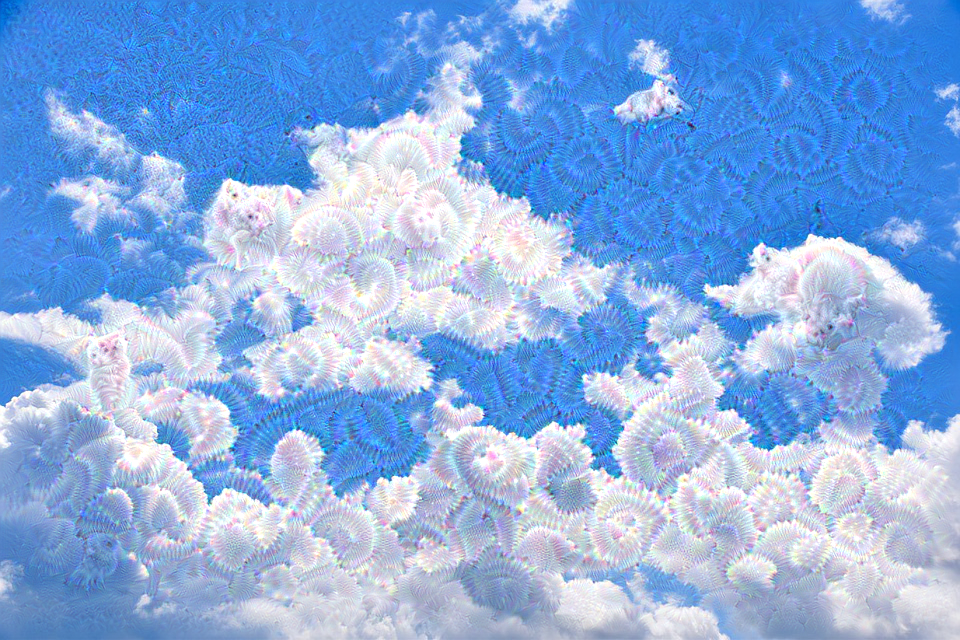

In [21]:
#el resultado
display(Image(result_prefix + ".png"))